In [ ]:
!pip install tensorflow
!pip install keras

##Importing important libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.core import Dropout
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

##Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

##Defining parameters to train

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

##Importing the dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Segmented",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1819 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['False Smut', 'Healthy', 'Leaf Blast', 'Leaf Scald', 'Neck Blast']

##Creating Helper Function to partition dataset

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

  

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

##Defining the preprocessing layers

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
model = Sequential()
height = 256
width = 256
depth = 3
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3,3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

###Architecture of our CNN Model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      1

##Compiling model with adam optimizer and Sparse Categorical Cross-Entropy Loss

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##Training the model

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,)

Epoch 1/50
45/45 [==============================] - 82s 329ms/step - loss: 0.9040 - accuracy: 0.7268 - val_loss: 12.9248 - val_accuracy: 0.2188
Epoch 2/50
45/45 [==============================] - 8s 182ms/step - loss: 0.5079 - accuracy: 0.8314 - val_loss: 31.5855 - val_accuracy: 0.1750
Epoch 3/50
45/45 [==============================] - 8s 182ms/step - loss: 0.2854 - accuracy: 0.8955 - val_loss: 7.0188 - val_accuracy: 0.5562
Epoch 4/50
45/45 [==============================] - 8s 183ms/step - loss: 0.1869 - accuracy: 0.9366 - val_loss: 2.7585 - val_accuracy: 0.7500
Epoch 5/50
45/45 [==============================] - 8s 183ms/step - loss: 0.1427 - accuracy: 0.9443 - val_loss: 1.6625 - val_accuracy: 0.7312
Epoch 6/50
45/45 [==============================] - 8s 184ms/step - loss: 0.1022 - accuracy: 0.9582 - val_loss: 0.3882 - val_accuracy: 0.9187
Epoch 7/50
45/45 [==============================] - 8s 184ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 2.7850 - val_accuracy: 0.6250
Epo

##Evaluating the model on test dataset

In [ ]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 6s 55ms/step - loss: 0.0024 - accuracy: 1.0000


##Training and Validation Plots

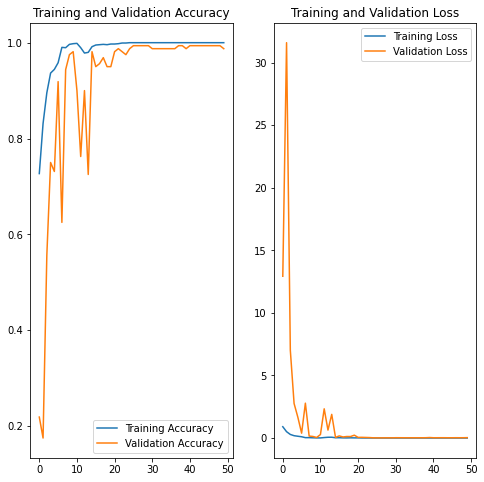

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Creating helper function to make batch prediction

In [ ]:
import numpy as np 
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

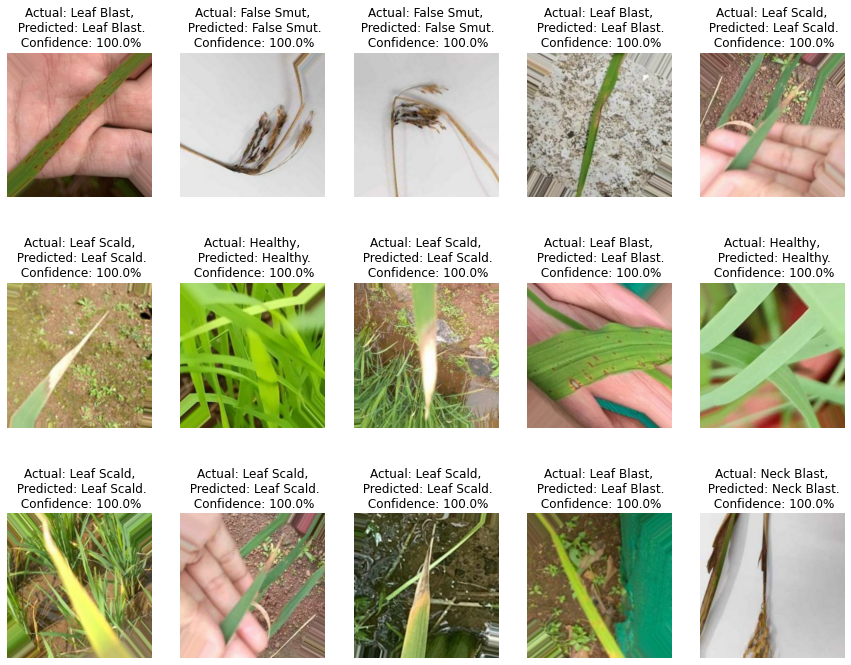

In [ ]:
plt.figure(figsize=(15, 12))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

##Saving model

In [ ]:
model.save("/content/drive/MyDrive/best_model_ever.h5")

##Creating confusion matrix for test dataset

In [ ]:
actual = []
pred = []
for i in range(15):
  for images, labels in test_ds.take(1):
      for i in range(15):
          predicted_class, confidence = predict(model, images[i].numpy())
          pred.append(predicted_class)
          actual_class = class_names[labels[i]] 
          actual.append(actual_class)

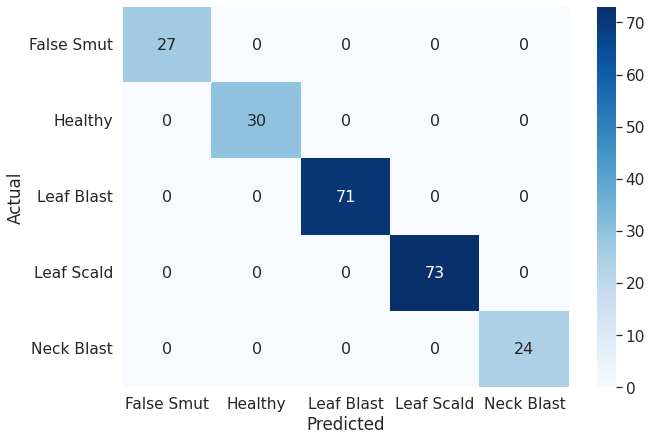

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
cf_matrix = confusion_matrix(actual, pred)
df_cm = pd.DataFrame(cf_matrix, columns=np.unique(actual), index = np.unique(actual))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=100, bbox_inches='tight' )

##Converting .h5 model to .tflite for the application

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/best_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/MyDrive/model_unquant.tflite', 'wb') as f:
  f.write(tflite_model)



INFO:tensorflow:Assets written to: /tmp/tmpz9dbpnys/assets


INFO:tensorflow:Assets written to: /tmp/tmpz9dbpnys/assets


###Visualizing the CNN

In [ ]:
mod =  tf.keras.models.load_model("/content/drive/MyDrive/best_model_ever.h5")

In [ ]:
mod.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_7 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)     

In [ ]:
lay = mod.layers
filters, biases = lay[0].get_weights()
print(lay[0].name, filters.shape)

conv2d_12 (3, 3, 3, 32)


##Filters of 1st convolutional layer

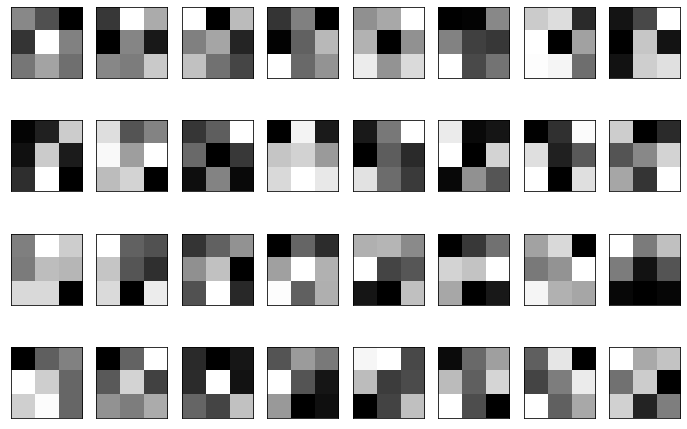

In [ ]:
fig1=plt.figure(figsize=(12, 8))
columns = 8
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([]) 
    fig1.set_yticks([])
    plt.imshow(f[:, :, 1],  cmap='gray') 
    #ix += 1
plt.show()   

##Filters of 4th convolution layer

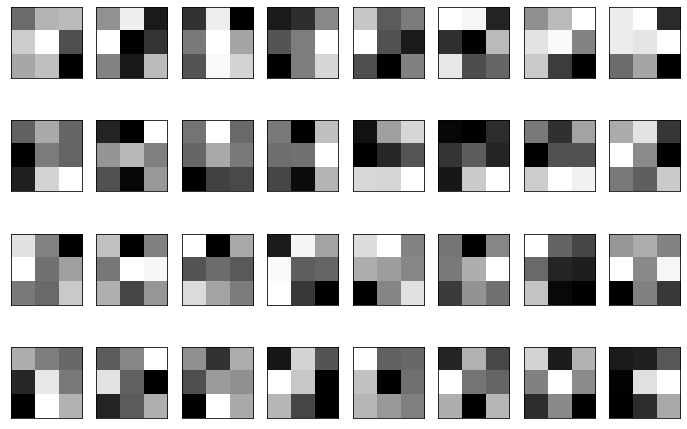

In [ ]:
fig1=plt.figure(figsize=(12, 8))
columns = 8
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  
    fig1.set_yticks([])
    plt.imshow(f[:, :, 1],  cmap='gray') 
    #ix += 1
plt.show()   

#Shorter version of the model to show output after every convolution

In [ ]:
conv_layer_index = [0, 5, 8, 11, 16, 19]  
outputs = [mod.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=mod.inputs, outputs=outputs)
# print(model_short.summary())

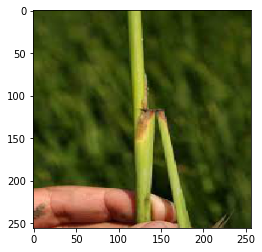

InvalidArgumentError: ignored

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
img = load_img('/content/dr_0_158.jpg', target_size=(256,256)) 
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
feature_output = model_short.predict(img)

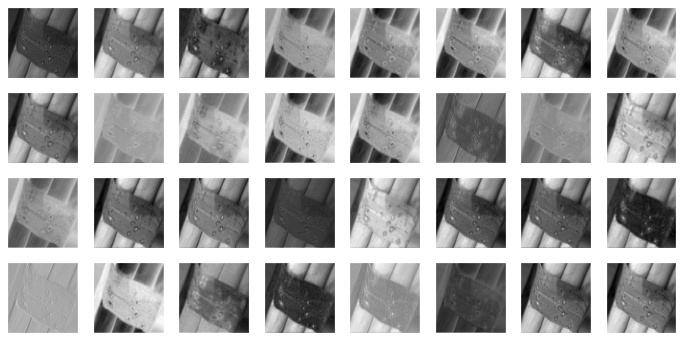

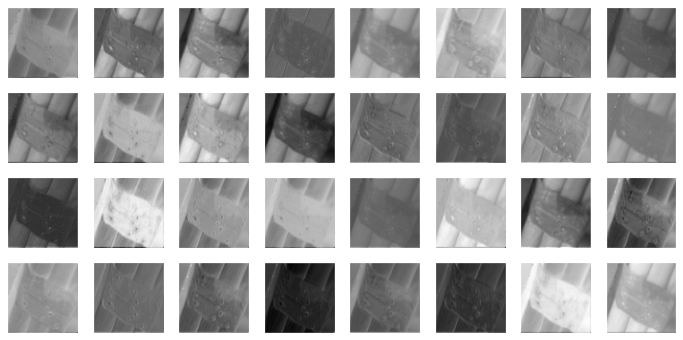

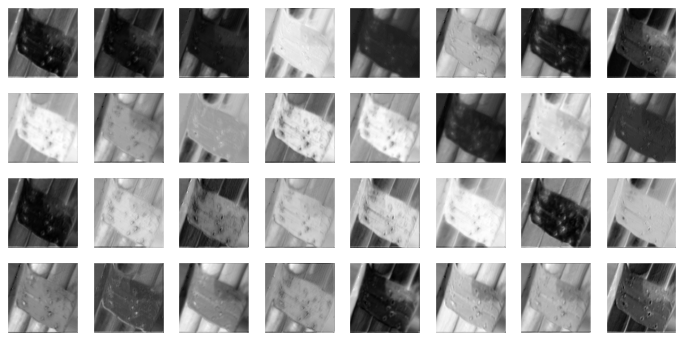

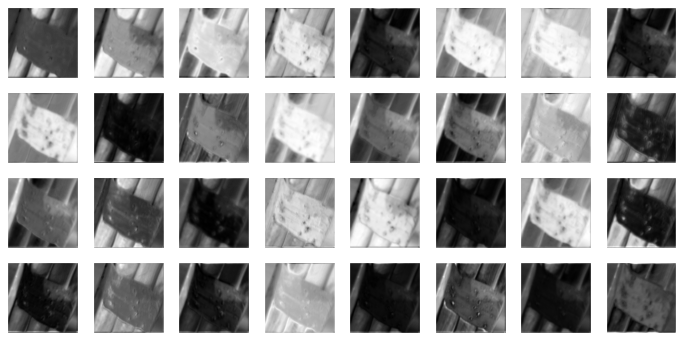

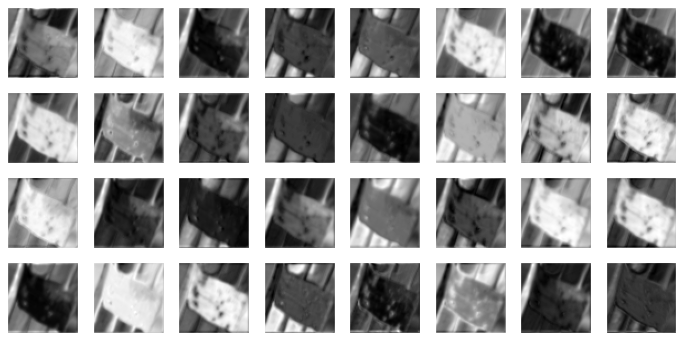

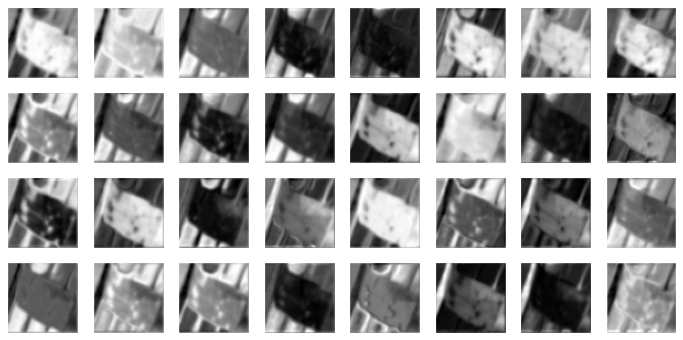

In [ ]:
import time
columns = 8
rows = 4
for ftr in feature_output:
    fig=plt.figure(figsize=(12, 6))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
    plt.show()
    

In [ ]:
model = tf.keras.models.Sequential([
#     resize_and_rescale,
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])

# model.build(input_shape=input_shape)